In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=012db1283f48c111ff09e1f88daea7b84282fa4fd70c7c395d6c081923ff058f
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 12.0 GB  | Proc size: 99.7 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total 15360MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import gc
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms,datasets,models
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import datetime
from PIL import Image
import warnings
from tqdm.notebook import tqdm
import random
import pandas as pd

In [ ]:
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)
random.seed(47)
torch.cuda.manual_seed(47)
torch.backends.cudnn.deterministic = True

In [ ]:
save_path = "./model_currency.pth"

In [ ]:

path = '/content/drive/MyDrive/currency rcognition/Train'
image_path = []
target = []
for i in os.listdir(path):
    for j in os.listdir(os.path.join(path, i)):
        image_path.append(os.path.join(path, i, j))
        target.append(i)


In [ ]:
table = {'image_path': image_path, 'target': target}
train_df = pd.DataFrame(data=table)
train_df = train_df.sample(frac = 1).reset_index(drop=True)

In [ ]:
path = '/content/drive/MyDrive/currency rcognition/Test'
image_path=[]
target=[]
for i in os.listdir(path):
    for j in os.listdir(os.path.join(path,i)):
        image_path.append(os.path.join(path,i,j))
        target.append(i)

In [ ]:
table = {'image_path': image_path, 'target': target}
test_df = pd.DataFrame(data=table)
test_df = test_df.sample(frac = 1).reset_index(drop=True)

In [ ]:
train_df.head()

,image_path,target
0,/content/drive/MyDrive/currency rcognition/Tra...,Fiftynote
1,/content/drive/MyDrive/currency rcognition/Tra...,2Hundrednote
2,/content/drive/MyDrive/currency rcognition/Tra...,5Hundrednote
3,/content/drive/MyDrive/currency rcognition/Tra...,2Hundrednote
4,/content/drive/MyDrive/currency rcognition/Tra...,Twentynote


In [ ]:
test_df.head()

,image_path,target
0,/content/drive/MyDrive/currency rcognition/Tes...,2Hundrednote
1,/content/drive/MyDrive/currency rcognition/Tes...,2Thousandnote
2,/content/drive/MyDrive/currency rcognition/Tes...,2Thousandnote
3,/content/drive/MyDrive/currency rcognition/Tes...,Twentynote
4,/content/drive/MyDrive/currency rcognition/Tes...,Tennote


In [ ]:
label_mapping = {"5Hundrednote": 0,
                "1Hundrednote": 1,
                "2Hundrednote": 2,
                "Tennote": 3,
                "Fiftynote": 4,
                "Twentynote": 5,
                "2Thousandnote": 6}
train_df['target'] = train_df['target'].map(label_mapping).astype(int)
test_df['target'] = test_df['target'].map(label_mapping).astype(int)

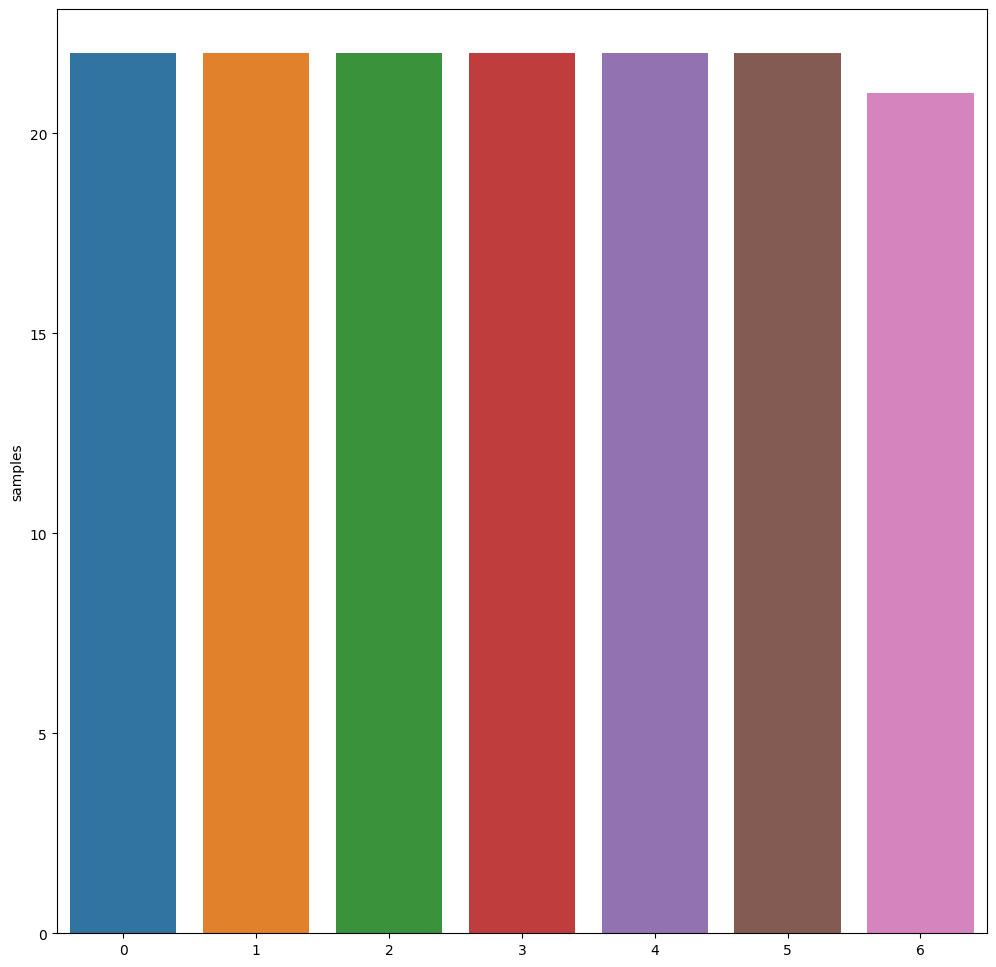

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 12))
x = train_df.target.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('samples')
plt.show()


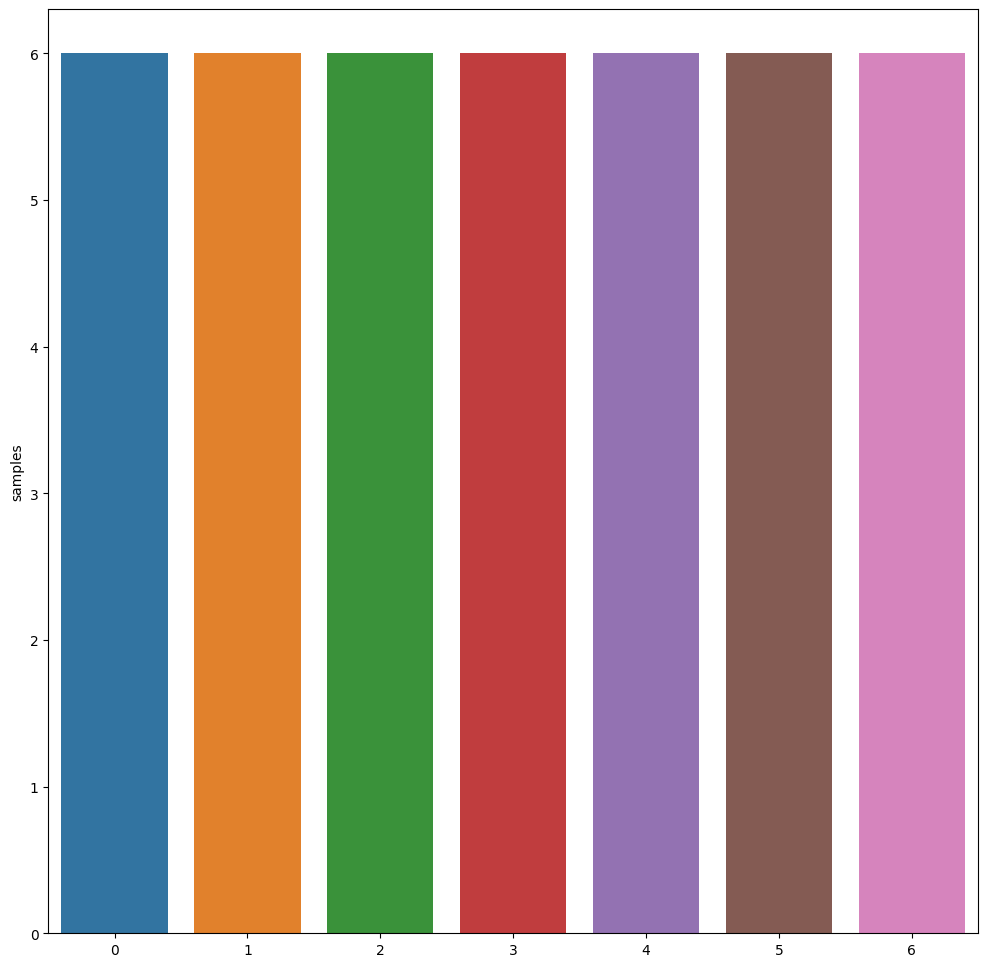

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 12))
x = test_df.target.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('samples')
plt.show()


In [ ]:
class CustomDataset(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self,index):
        image = self.dataframe.iloc[index]['image_path']
        image = cv2.imread(image)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = int(self.dataframe.iloc[index]["target"])
        return {"image": torch.tensor(image, dtype=torch.float), "targets": torch.tensor(label, dtype = torch.long)}

In [ ]:
def get_model(classes=7):
    model = models.resnet50(pretrained=True)
    features = model.fc.in_features
    model.fc = nn.Linear(in_features = features, out_features = classes)
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = get_model()
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [ ]:
optimizer  = optim.Adam(model.parameters(),lr = 0.00003)
loss_function = nn.CrossEntropyLoss()
train_dataset = CustomDataset(
dataframe=train_df,
transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 4)
valid_dataset = CustomDataset(
dataframe=test_df,
transform=test_transform)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
best_accuracy = 0

In [ ]:
for epochs in tqdm(range(15),desc="Epochs"):
    model.train()
    for data_in_model in tqdm(train_loader, desc="Training"):
        inputs = data_in_model['image']
        target = data_in_model['targets']

        inputs = inputs.to(device, dtype = torch.float)
        targets = target.to(device, dtype = torch.long)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs,targets)
        loss.backward()
        optimizer.step()

    model.eval()
    final_targets = []
    final_outputs = []
    val_loss = 0
    with torch.no_grad():
        for data_in_model in tqdm(valid_loader, desc="Evaluating"):
            inputs = data_in_model['image']
            targets = data_in_model['targets']

            inputs = inputs.to(device, dtype = torch.float)
            targets = targets.to(device, dtype = torch.long)

            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss
            _,predictions = torch.max(outputs, 1)

            targets = targets.detach().cpu().numpy().tolist()
            predictions = predictions.detach().cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(predictions)
    PREDS = np.array(final_outputs)
    TARGETS = np.array(final_targets)
    acc = (PREDS == TARGETS).mean() * 100
    if(acc>best_accuracy):
        best_accuracy = acc
        torch.save(model.state_dict(), save_path)
    print("EPOCH: {}/10".format(epochs+1))
    print("ACCURACY---------------------------------------------------->{}".format(acc))
    print("LOSS-------------------------------------------------------->{}".format(val_loss))

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 1/10
ACCURACY---------------------------------------------------->61.904761904761905
LOSS-------------------------------------------------------->4.722010612487793


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 2/10
ACCURACY---------------------------------------------------->88.09523809523809
LOSS-------------------------------------------------------->3.5326712131500244


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 3/10
ACCURACY---------------------------------------------------->95.23809523809523
LOSS-------------------------------------------------------->2.5736560821533203


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 4/10
ACCURACY---------------------------------------------------->100.0
LOSS-------------------------------------------------------->1.817528247833252


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 5/10
ACCURACY---------------------------------------------------->100.0
LOSS-------------------------------------------------------->1.2888197898864746


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 6/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.9405548572540283


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 7/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.7790772914886475


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 8/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.6529451608657837


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 9/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.5730814933776855


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 10/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.5144866704940796


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 11/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.4695925712585449


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 12/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.470367968082428


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 13/10
ACCURACY---------------------------------------------------->97.61904761904762
LOSS-------------------------------------------------------->0.41855037212371826


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 14/10
ACCURACY---------------------------------------------------->100.0
LOSS-------------------------------------------------------->0.36921724677085876


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

EPOCH: 15/10
ACCURACY---------------------------------------------------->100.0
LOSS-------------------------------------------------------->0.34103861451148987


In [ ]:
def test_model(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(image).unsqueeze(0)

    # Make predictions
    model.eval()
    input_image = input_image.to(device, dtype=torch.float)
    with torch.no_grad():
        output = model(input_image)
    _, predicted_class = torch.max(output, 1)

    class_labels = ['5Hundrednote', '1Hundrednote', '2Hundrednote', 'Tennote', 'Fiftynote', 'Twentynote', '2Thousandnote']
    predicted_label = class_labels[predicted_class.item()]

    return predicted_label

test_image_path = "/content/drive/MyDrive/currency rcognition/1.jpg"
predicted_currency = test_model(model, test_image_path)

print(f"The predicted currency is: {predicted_currency}")


The predicted currency is: 1Hundrednote


In [ ]:
!pip install pyttsx3

In [ ]:
!pip install gtts

In [ ]:
from gtts import gTTS

In [ ]:

def test_model(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(image).unsqueeze(0)

    # Make predictions
    model.eval()
    input_image = input_image.to(device, dtype=torch.float)
    with torch.no_grad():
        output = model(input_image)
    _, predicted_class = torch.max(output, 1)

    class_labels = ['5Hundrednote', '1Hundrednote', '2Hundrednote', 'Tennote', 'Fiftynote', 'Twentynote', '2Thousandnote']
    predicted_label = class_labels[predicted_class.item()]

    return predicted_label

# Test the model on an Indian currency image
test_image_path = "/content/drive/MyDrive/currency rcognition/1.jpg"  # Replace with your actual path
predicted_currency = test_model(model, test_image_path)

print(f"The predicted currency is: {predicted_currency}")

# Convert the predicted currency to speech
tts = gTTS(text=predicted_currency, lang='en')
tts.save('predicted_currency3.mp3')

# Play the speech
os.system('predicted_currency3.mp3')

The predicted currency is: 1Hundrednote


32512

In [ ]:

def test_model(model, image_path):

    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(image).unsqueeze(0)

    # Make predictions
    model.eval()
    input_image = input_image.to(device, dtype=torch.float)
    with torch.no_grad():
        output = model(input_image)
    _, predicted_class = torch.max(output, 1)

    class_labels = ['5Hundrednote', '1Hundrednote', '2Hundrednote', 'Tennote', 'Fiftynote', 'Twentynote', '2Thousandnote']
    predicted_label = class_labels[predicted_class.item()]

    return predicted_label


test_image_path = "/content/drive/MyDrive/currency rcognition/1.jpg"
predicted_currency = test_model(model, test_image_path)

print(f"The predicted currency is: {predicted_currency}")

# Convert the predicted currency to speech
tts = gTTS(text=predicted_currency, lang='en')
tts.save('predicted_currency1.mp3')

# Play the speech
os.system('predicted_currency3.mp3')

The predicted currency is: 1Hundrednote


32512

In [ ]:
pip install pytesseract


In [ ]:
import requests

# Replace 'YOUR_API_KEY' with your actual API key
api_key = 'K84043028588957'

# URL for OCR.space API
api_url = 'https://api.ocr.space/parse/image'

# Path to your image file
image_path = '/content/drive/MyDrive/currency rcognition/v4-460px-Write-a-Bill-for-Payment-Step-1-Version-4.jpg.jpg'

# Define the parameters for the API request
payload = {
    'apikey': api_key,
    'language': 'eng',  # Specify the language (e.g., 'eng' for English)
    'isOverlayRequired': False,
}

# Open and read the image file
with open(image_path, 'rb') as image_file:
    # Make the API request
    response = requests.post(api_url, files={'image': image_file}, data=payload)

# Parse the response
result = response.json()

# Extracted text will be in result['ParsedResults'][0]['ParsedText']
extracted_text = result['ParsedResults'][0]['ParsedText']

# Print the extracted text
print(extracted_text)


In [ ]:
import requests

# Replace 'YOUR_API_KEY' with your actual OCR.space API key
api_key = 'K84043028588957'

# URL for OCR.space API
api_url = 'https://api.ocr.space/parse/image'

# Path to your bill image
image_path = '/content/418S3TgVd-L._AC_UF1000,1000_QL80_.jpg'

# Define the parameters for the API request
payload = {
    'apikey': api_key,
    'language': 'eng',
    'isOverlayRequired': False,
}

# Open and read the image file
with open(image_path, 'rb') as image_file:
    # Make the API request
    response = requests.post(api_url, files={'image': image_file}, data=payload)

# Parse the response
result = response.json()

# Extracted text will be in result['ParsedResults'][0]['ParsedText']
extracted_text = result['ParsedResults'][0]['ParsedText']

# Split the text into lines
lines = extracted_text.split('\n')

# Search for keywords related to the total amount
keywords = ['total', 'amount', 'due']

# Initialize total amount to None
total_amount = None

# Iterate through the lines to find the total amount
for line in lines:
    for keyword in keywords:
        if keyword in line.lower():
            # Extract the numerical value (assuming it's after the keyword)
            words = line.split()
            for word in words:
                if word.replace('.', '', 1).isdigit():  # Check if it's a numeric value
                    total_amount = float(word)
                    break

# Print the total amount
if total_amount is not None:
    print(f'Total Amount: ${total_amount:.2f}')
else:
    print('Total amount not found.')
